## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.

* **To be submitted by next session**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


In [1]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from matplotlib import cm

%matplotlib inline

### Download the Model
We provide you a pretrained model `VGG-16` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **VGG-16**: A deep architecture for image classification.

![vgg_16.png](https://www.researchgate.net/profile/Bibo_Shi/publication/323440752/figure/fig1/AS:739814685032448@1553396974148/The-architecture-of-VGG-16-model-To-represent-different-depth-levels-convolutional.jpg)

In [2]:
# The downloading process may take a few minutes. 
vgg_model = models.vgg16(pretrained=True)# return the vgg-16 model pretrained on ImageNet dataset.

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course; notice that the images should be placed in a **sub**-directory of the path indicated below).<br>
In order to use the pretrained model vgg-16, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [3]:
# Define preprocessing function of the input images
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [4]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them
dir_path = "data/" 
dataset = preprocess_image(dir_path)

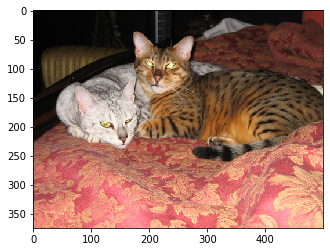

In [5]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

Predict the label of the input image, and print the top-3 possible classes

In [7]:
output = vgg_model(dataset[index][0].view(1, 3, 224, 224))

values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy())
print("Raw class scores:", values[0].detach().numpy())

# 285: 'Egyptian cat'
# 281: 'tabby, tabby cat'
# 282: 'tiger cat'

Top 3-classes: [285 281 282]
Raw class scores: [23.208353 21.070581 19.795198]


In [8]:
def show_results(self,image):
    img = cv2.resize(np.float32(image), (224, 224)) / 255
    print(img.shape)
    heatmap=cv2.applyColorMap(np.uint8(255*self.cam), cv2.COLORMAP_JET)
    print(heatmap.shape)
    heatmap = np.float32(heatmap) / 255
    results = heatmap + np.float32(img)
    results = results / np.max(results)
    #plt.imshow(results)

### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model vgg-16 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. Run `print(vgg_model)` to get more information on VGG model.
 + The size of feature maps is 14x14, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

![Grad_CAM](https://upload-images.jianshu.io/upload_images/415974-0147c44dcfb8cc1c.jpg)

In [9]:
class Grad_CAM:
    def __init__(self,model,layer):
        self.model=model
        self.model.eval()
        self.layer=layer
        self.outputs=[]
        self.gradients=[]
        self.nclasses=model._modules.get('classifier')[-1].out_features #1000
        self.cam=None
        
    def reset(self):
        self.__init__(self.model,self.layer)    
        
    def save_output(self,m,i,o):
        self.outputs.append(o)
    
    def feature_extract(self,image):
        h=self.layer.register_forward_hook(self.save_output)
        s=self.model(image.view(1, 3, 224, 224))
        return self.outputs,s
    
    def save_grads(self,m,i,o):
        self.gradients.append(o)
        
    def get_grads(self):
        h2=self.layer.register_backward_hook(self.save_grads)
        return self.gradients
    
    def compute_cam(self,image,target_index=None):
        self.reset()
        for i in range(2):
            outputs, output = self.feature_extract(image)
            out= np.zeros((1,self.nclasses),dtype=np.float32)
            if target_index==None:
                target_index=int(output.argmax(dim=1))
            out[0][target_index]=1    
            out = torch.from_numpy(out).requires_grad_(True)
            out = torch.sum(out * output)
    
            self.model.features.zero_grad()
            self.model.classifier.zero_grad()
            out.backward(retain_graph=True)
        
            grads_vals=self.get_grads()
            
        grads_val = grads_vals[0][-1].cpu().data.numpy()

        target = outputs[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        local_cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            local_cam += w * target[i, :, :]

        local_cam = np.maximum(local_cam, 0)
        local_cam = cv2.resize(local_cam, (224, 224))
        local_cam = local_cam - np.min(local_cam)
        local_cam = local_cam / np.max(local_cam)
        self.cam = local_cam
        return target, grads_val
        
    def show_results(self,image):
        mean=np.array([0.485, 0.456, 0.406])
        std=np.array([0.229, 0.224, 0.225])
        img=np.array(image).transpose((1,2,0))
        img=img*std+mean
        heatmap=cm.jet(self.cam)[:,:,0:3]
        results=heatmap + img
        results=results/np.max(results)
        plt.imshow(results)

In [10]:
layer=vgg_model._modules.get('features')[28]
grad_cam = Grad_CAM(vgg_model, layer)

In [6]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
def plot_images(index):
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    fig=plt.figure(figsize=(16,5))
    image=dataset[index][0]
    img=np.array(image).transpose((1,2,0))
    img=img*std+mean
    output = vgg_model(image.view(1, 3, 224, 224))
    values, indices = torch.topk(output, 3)
    TOP3_Classes=indices[0].numpy()
    plt.suptitle("Heatmaps of the top 3 classes for the image with index "+str(index), y=1, fontsize=14)
    for i in range(len(TOP3_Classes)+1):
        if i==0: 
            plt.subplot(1,4,i+1)
            plt.title('original image')
            plt.imshow(img)
        else :    
            target_index=TOP3_Classes[i-1]
            grad_cam.compute_cam(image,target_index)
            plt.subplot(1,4,i+1)
        
            if i==1: plt.title('Heatmaps of the first class')
            if i==2: plt.title('Heatmaps of the second class')
            if i==3: plt.title('Heatmaps of the third class')
            grad_cam.show_results(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


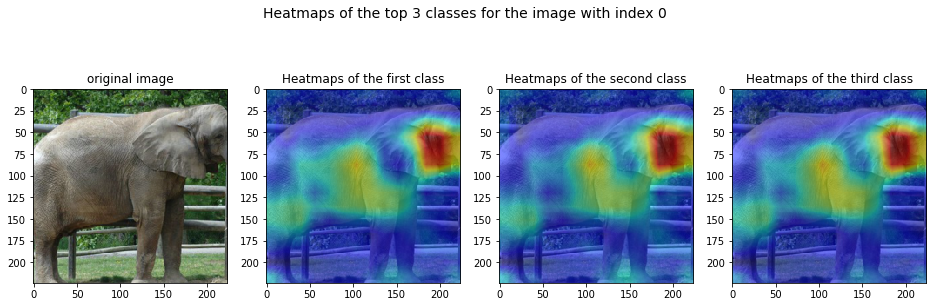

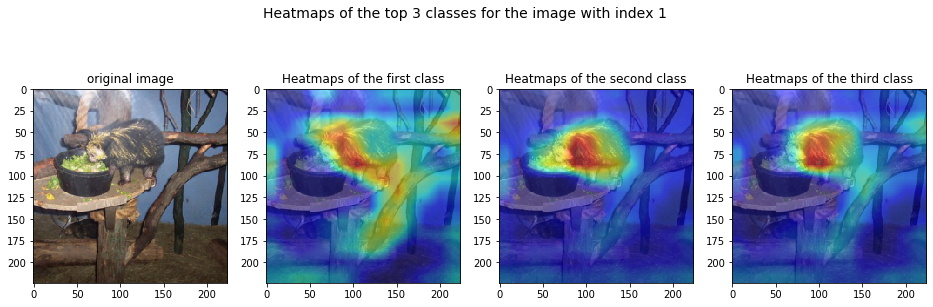

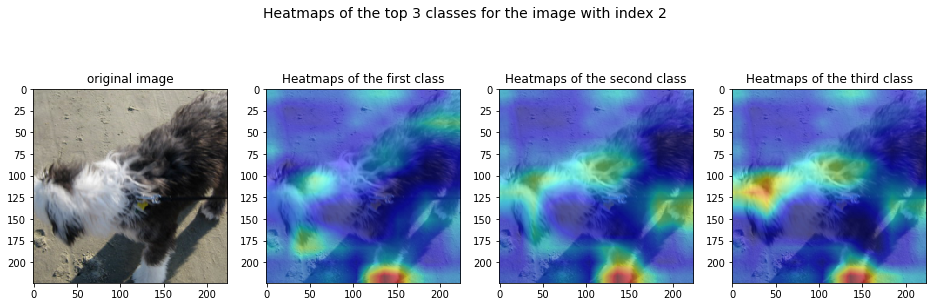

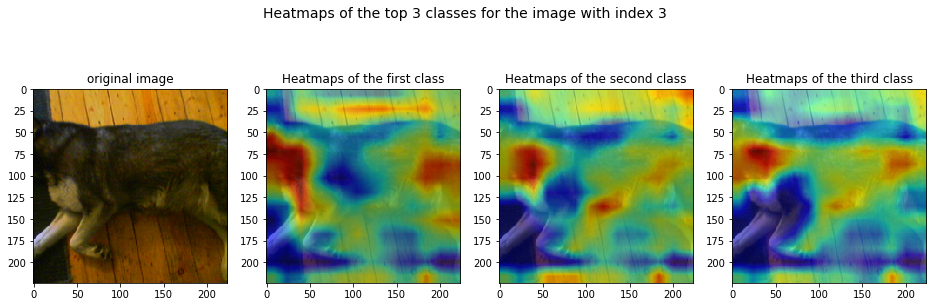

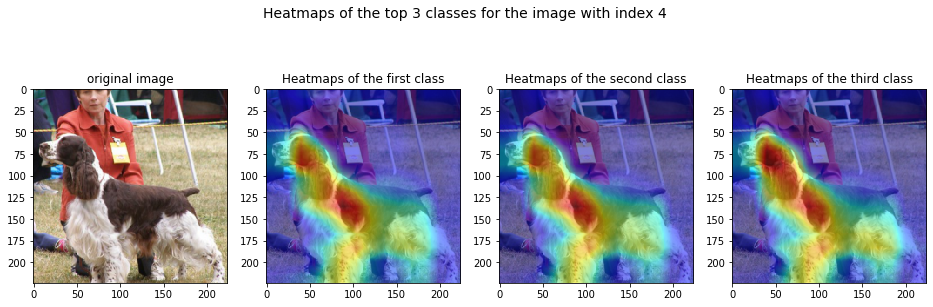

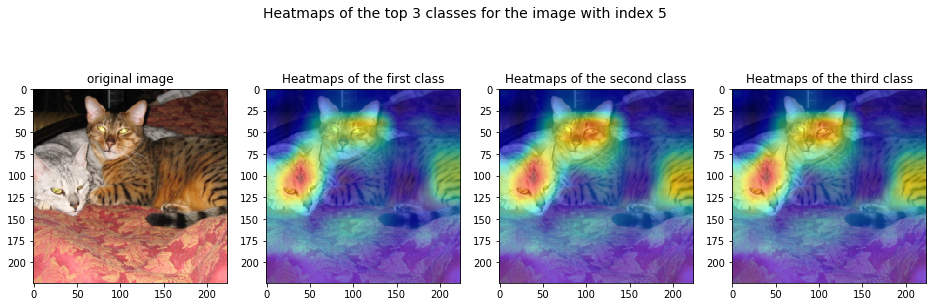

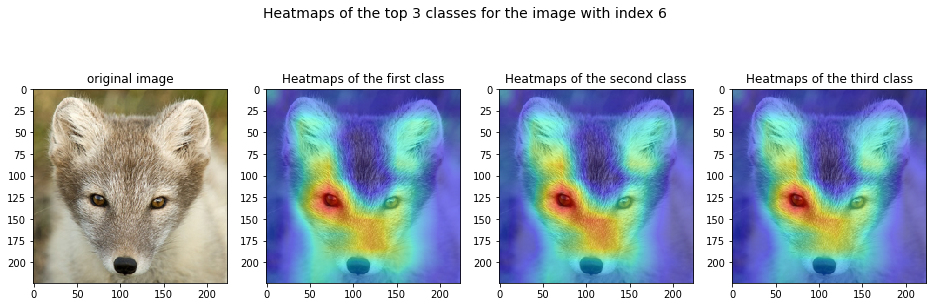

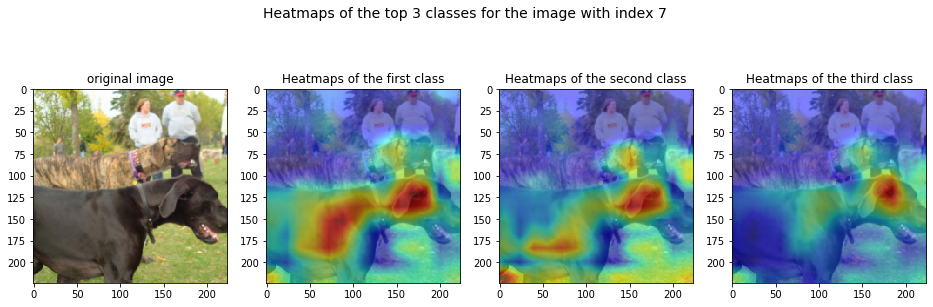

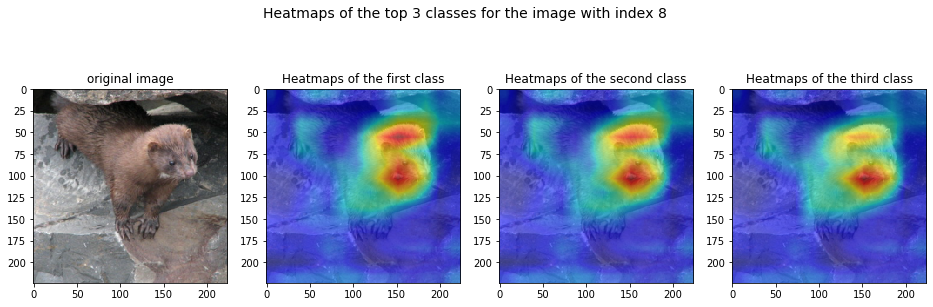

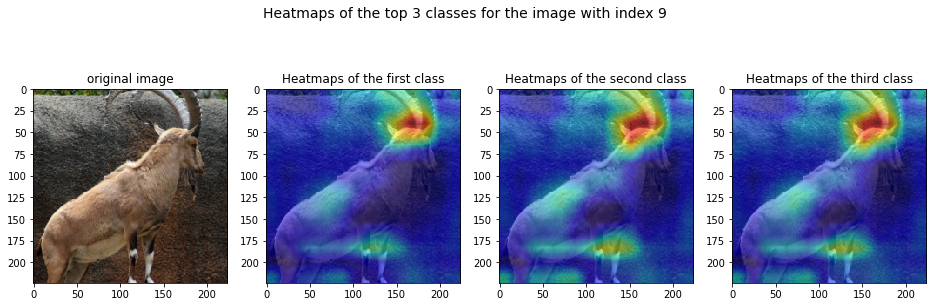

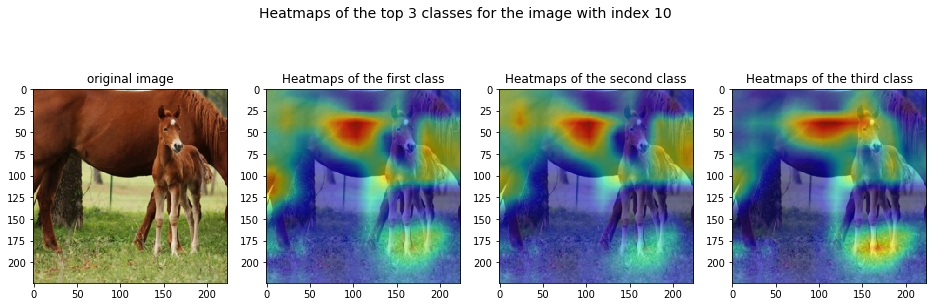

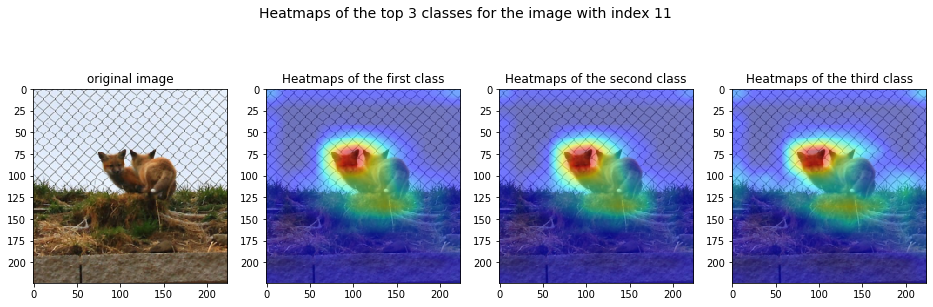

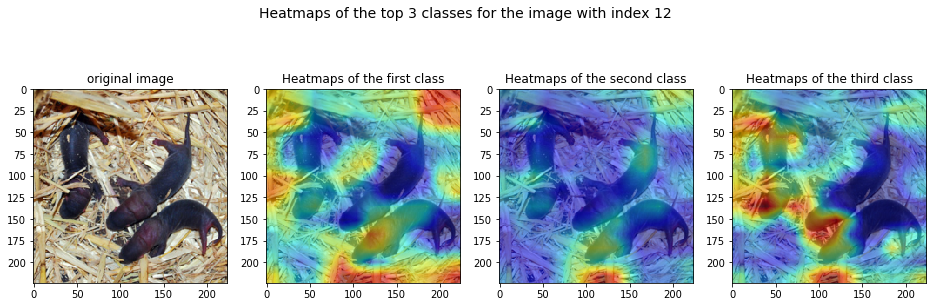

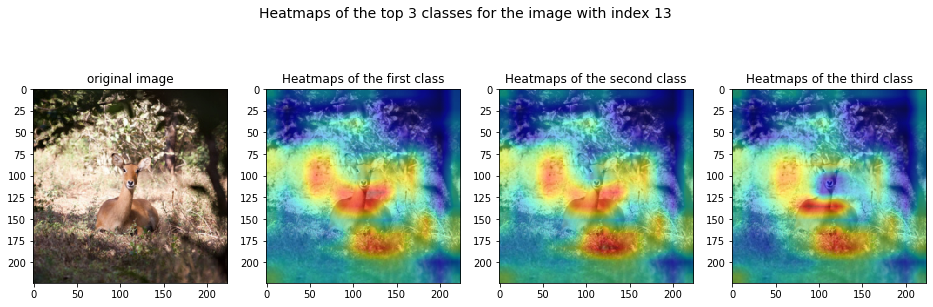

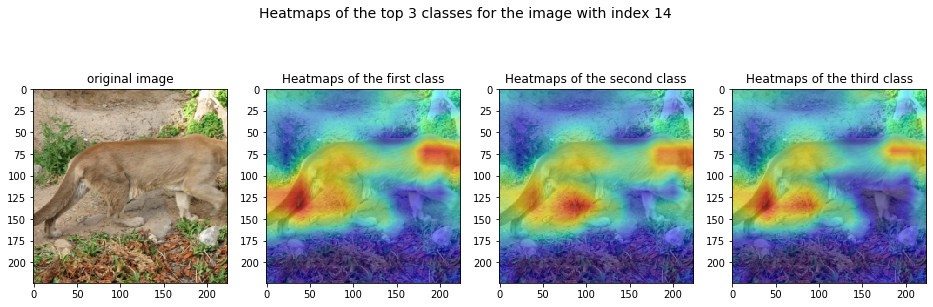

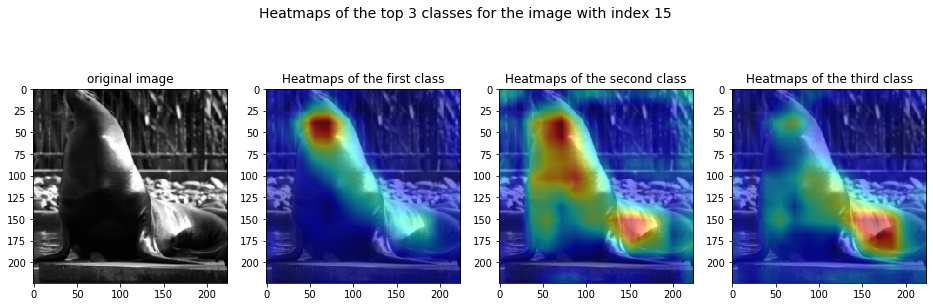

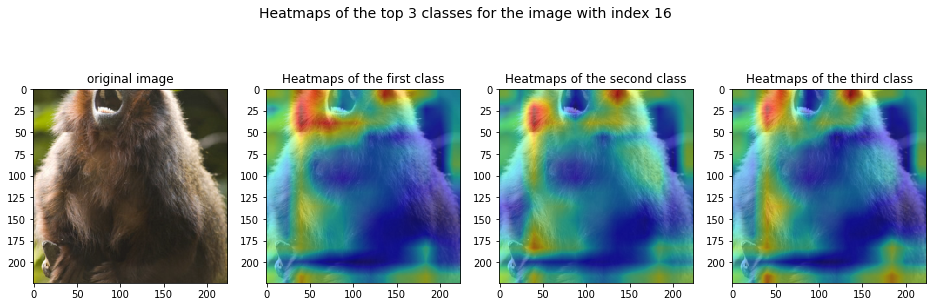

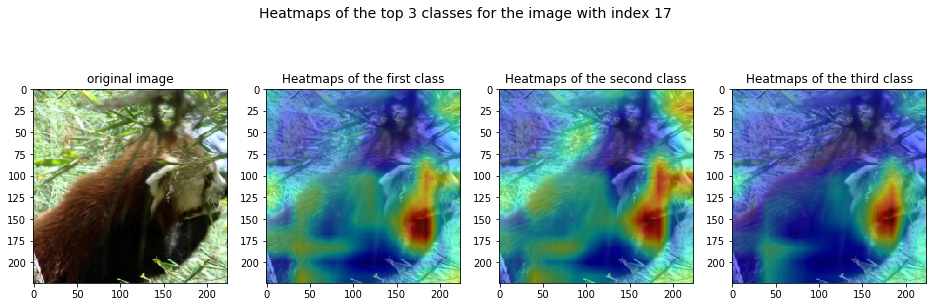

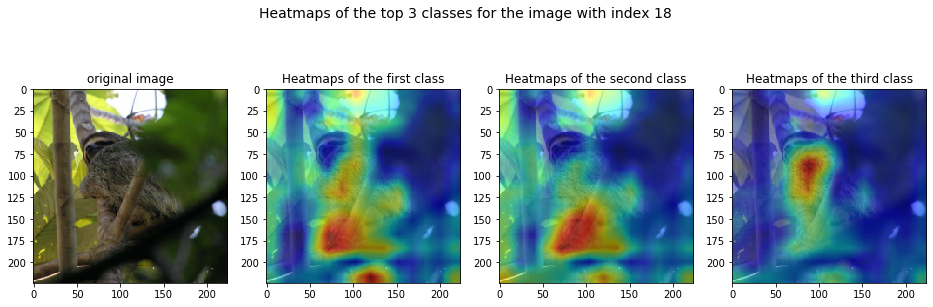

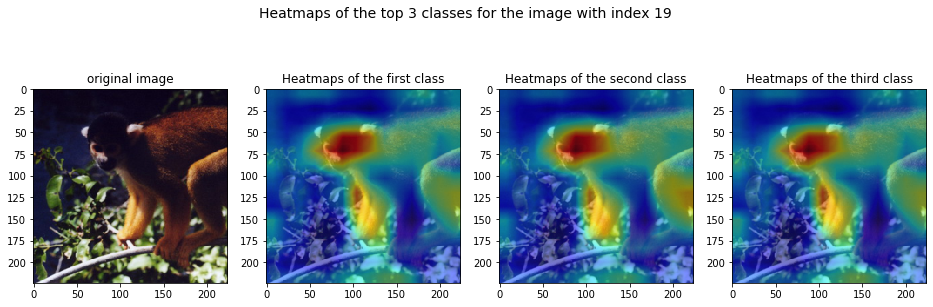

In [11]:
for k in range(20):
    plot_images(k)

In [28]:
import json
with open('imagenet_class_index.json') as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

image=dataset[0][0]
output = vgg_model(image.view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
TOP3_Classes=indices[0].numpy()
print(TOP3_Classes)
print(idx2label[TOP3_Classes[0]] ,idx2label[TOP3_Classes[1]] ,idx2label[TOP3_Classes[2]])

[385 386 101]
Indian_elephant African_elephant tusker


In [29]:
values

tensor([[27.6106, 26.5685, 25.5989]], grad_fn=<TopkBackward>)

In each case, we can see the region of the image that make the model predict the class. It is particularly useful in analyzing wrongly classified samples.
In general, we have the same regions for the top 3 classes since the 3 classes are very close.

In the first example, we can see the areas of the image that make the model take the decision which class ('Indian elephant') to assign to the image. We can assume that the model took the shape of the head of the elephants as a strong sign of the presence of an elephant in the image. In this case, the top 3 classes are different type of elephants and the scores are very close (27.61, 26.58, 25.59). 

In some cases like for index= 1, we have more chance to have a misclassification since the model take into account a part of a tree to make the prediction.


